In [22]:
import pandas as pd
import numpy as np
from linearmodels.panel import PanelOLS
import matplotlib.pyplot as plt
import random

# Set seed
np.random.seed(4)

# Simulation parameters
n_stocks = 100
n_periods = 20
# Define stock IDs and quarters
stocks = [f"Stock_{i}" for i in range(n_stocks)]
quarters = list(range(n_periods))  # Q0, Q1, ..., Q19


# Create full panel
index = pd.MultiIndex.from_product([stocks, quarters], names=["stock_id", "quarter"])
df = pd.DataFrame(index=index).reset_index()

# Simulate predictors
df["momentum"] = np.random.normal(0, 1, len(df))
df["volatility"] = np.random.normal(0, 1, len(df))

# Generate fixed effects
stock_effects = {stock: np.random.normal(0, 0.5) for stock in stocks}
time_effects = {quarter: np.random.normal(0, 0.5) for quarter in quarters}

# Heterogeneous momentum effect
def get_momentum_slope(stock):
    return 0.5 + 0.3 * random.random()

df["return"] = (
    df.apply(lambda row: get_momentum_slope(row["stock_id"]) * row["momentum"], axis=1) +
    0.2 * df["volatility"] +
    df["stock_id"].map(stock_effects) +
    df["quarter"].map(time_effects) +
    np.random.normal(0, 0.3, len(df))
)

# Convert to panel format
df = df.set_index(["stock_id", "quarter"])

df.head(20)


momentum  volatility    return
stock_id quarter                                
Stock_0  0        0.050562    0.029539  1.259725
         1        0.499951   -0.585908  0.302628
         2       -0.995909    0.308234  0.284682
         3        0.693599    0.808108  1.365532
         4       -0.418302    0.134052  0.063195
         5       -1.584577   -0.777152 -0.375695
         6       -0.647707   -2.509752 -1.070635
         7        0.598575    0.156162  1.163820
         8        0.332250    0.469941  0.741944
         9       -1.147477    0.208255 -0.047702
         10       0.618670   -1.686744  0.873627
         11      -0.087987   -0.799654  0.621568
         12       0.425072   -1.793591  0.734831
         13       0.332253    0.040181  1.240239
         14      -1.156816   -0.849261 -0.316013
         15       0.350997    0.222380  0.246128
         16      -0.606887   -0.683954 -0.196080
         17       1.546979   -1.488976  1.798703
         18       0.723342   -1.435819  1.063222
         19       0.046136    0.540828  0.406901

In [23]:
# Run the fixed effects model
model = PanelOLS(
    dependent=df["return"],
    exog=df[["momentum", "volatility"]],
    entity_effects=True,
    time_effects=True
)
results = model.fit(cov_type="clustered", cluster_entity=True)

# Print summary
print(results.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:                 return   R-squared:                        0.8200
Estimator:                   PanelOLS   R-squared (Between):              0.0736
No. Observations:                2000   R-squared (Within):               0.7056
Date:                Fri, Apr 11 2025   R-squared (Overall):              0.5066
Time:                        17:18:39   Log-likelihood                   -422.71
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      4281.0
Entities:                         100   P-value                           0.0000
Avg Obs:                       20.000   Distribution:                  F(2,1879)
Min Obs:                       20.000                                           
Max Obs:                       20.000   F-statistic (robust):             3547.2
                            

In [24]:
# Predictions
df["predicted_return"] = results.predict().fitted_values
df_reset = df.reset_index()

df.head()

momentum  volatility    return  predicted_return
stock_id quarter                                                  
Stock_0  0        0.050562    0.029539  1.259725          0.038598
         1        0.499951   -0.585908  0.302628          0.204967
         2       -0.995909    0.308234  0.284682         -0.581147
         3        0.693599    0.808108  1.365532          0.610568
         4       -0.418302    0.134052  0.063195         -0.243170

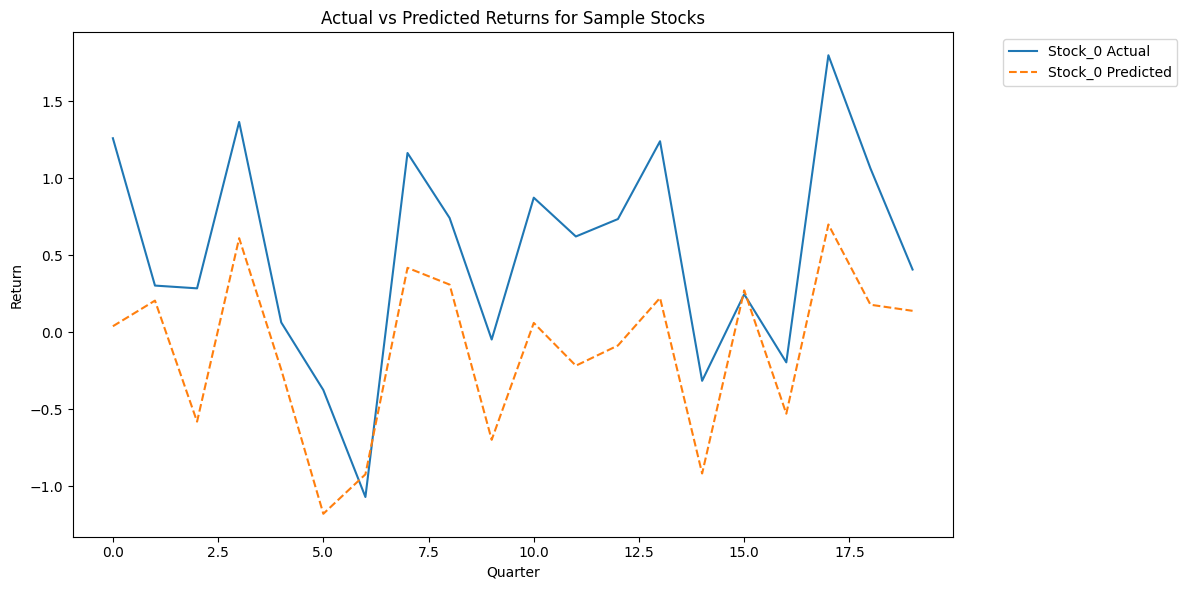

In [25]:
# Plot for first 5 stocks
fig, ax = plt.subplots(figsize=(12, 6))
sample_stocks = df_reset["stock_id"].unique()[:1]

for stock in sample_stocks:
    stock_data = df_reset[df_reset["stock_id"] == stock]
    ax.plot(stock_data["quarter"], stock_data["return"], label=f"{stock} Actual", linestyle='-')
    ax.plot(stock_data["quarter"], stock_data["predicted_return"], label=f"{stock} Predicted", linestyle='--')

ax.set_title("Actual vs Predicted Returns for Sample Stocks")
ax.set_xlabel("Quarter")
ax.set_ylabel("Return")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()